In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
def plot_sys(v,t):
        plt.plot(t,v(t))
        plt.xlabel('Quantity of water consumed')
        plt.ylabel('Average rate of flow')

In [6]:
k_0 = 350#Carrying capacity 
x_0 =300
def logistic(q, k=k_0,r= 0.01):
    return k_0/(1+ np.exp(-r*(q-x_0)))

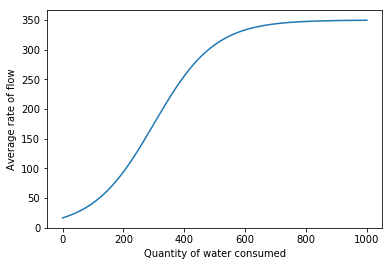

In [7]:
x = np.linspace(1,6, 10)
q= np.linspace(0,1000,10000)
plot_sys(logistic,q)
plt.show()

In [8]:
s_0 = 1000
# Requires: v0: initial volume
#           T:  timesteps
#           T_drink: times of drinking
#           Q: The corresponding amount drunk
#           s0: the constant of threshold for firing
#           k, r: the parameters of logistic
#           PROP: proportion of the water drunk that reaches bladder (const. set to 0.68)
# Modifies: nothing
# Returns: V, the volume of liquid in bladder
#          R, the rates
def integ_fire(T, T_drink, Q, model_type = 1,
               v0=0, s0=s_0, k=k_0, r=0.01, PROP=0.68):
    
        q = np.linspace(0,1000,10000)
        MINr = min(logistic(q,k,r)) 
        epsilon_r = 0
        thresh = s0 # modify if needed
        V = np.zeros(len(T)) # volume of liquid in bladder
        R = np.zeros(len(T)) # keeping R
        
        rbar = 0#float(logistic(np.mean(q), k, r)) /60 # a default value
        t_total = T[-1]#PROP*np.mean(q)/rbar # a default value 
        q = 0
        
        i_drink = 0
        t_prevDrink = 0
        
        for i, t in enumerate(T[:-1]):
            
            if (V[i] > thresh):
                #print('Fire')
                V[i+1] = 0
                continue
                
            if (t in T_drink):
              
                if (t-t_prevDrink > t_total):
                    q = Q[i_drink]
                else:
                    #print('early drink')
                    q = (1/PROP)*rbar*(t_total - (t - t_prevDrink)) + Q[i_drink]
                
                rbar = logistic(q, k, r)/60 # from ml/hr to ml/min
                #print(rbar)
                t_total = PROP*q/rbar
                i_drink += 1
                t_prevDrink = t
            if model_type == 1:
                rate = rbar # this is for const rate
                V[i+1] = V[i] + rate
                R[i] = rate
            elif model_type == 2:
                rate = max(2*rbar*(1 - (t-t_prevDrink)/t_total), 0) # this is dV/dt # this is for variable r
                V[i+1] = V[i] + rate
                R[i] = rate
            

            
        return V, R
                    

In [9]:
T = [x for x in range(24*60)] # over a day

T_drink = set()
Q = []
for i in range(20):
    #chooses 20 random times to drink in the day
    T_drink.add(random.choice(T))
    Q = Q + [random.randint(0, 500)]
    

In [10]:
np.array(T_drink)

array(set([1059, 996, 1061, 902, 263, 1288, 1180, 388, 524, 973, 462, 829, 856, 183, 56, 964, 81, 349, 1438, 287]), dtype=object)

In [11]:
sum(np.array(Q))

4779

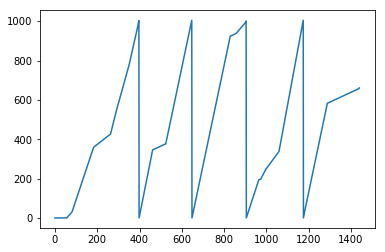

In [12]:
intfi = integ_fire(T, T_drink, Q, 1)
plt.plot(T, intfi[0])
plt.show()

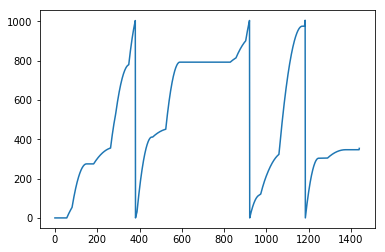

In [13]:
intfi = integ_fire(T, T_drink, Q, 2)
plt.plot(T, intfi[0])
plt.show()

In [91]:
s_0 = 1000
# Requires: 
#           v0: initial volume
#           T:  timesteps
#           T_drink: times of drinking
#           Q: The corresponding amount drunk
#           s0: the constant of threshold for firing
#           k, r: the parameters of logistic
#           PROP: proportion of the water drunk that reaches bladder (const. set to 0.68)
#           n: number of oscillators involved this has to be 2 for now!
#           delta: the time one spends in/on the way to bathroom (in minutes)
# Modifies: nothing
# Returns: V, the volume of liquid in bladder
#          R, the rates
def coupled_integ_fire(T, T_drink, Q, model_type = 1,
               v0=0, s0 = s_0, k=k_0, r=0.01, PROP=0.68, 
                       n = 2, delta = 5):
        
        q = np.linspace(0,1000,10000)
        MINr = min(logistic(q,k,r)) 
        epsilon_r = 0
        thresh = np.ndarray(n) # modify if needed
        thresh[:] = s_0
        V = [np.zeros(len(T)) for x in range(n)] # volume in bladders
        R = [np.zeros(len(T)) for x in range(n)]  # keeping Rs
        
        rbar = [0 for x in range(n)]#float(logistic(np.mean(q), k, r)) /60 # a default value
        t_total = [T[-1] for x in range(n)]#PROP*np.mean(q)/rbar # a default value 
        q = np.ndarray(n)
        q[:] = 0
        
        i_drink = [0, 0]
        t_prevDrink = np.ndarray(n)
        t_prevDrink[:] = 0
        
        for osc in range(n):
            # if they see each other in the bathroom, they try to go later
            # next time
            if (sum(t_prevDrink) > 0
                and abs(t_prevDrink[n-osc] - t_prevDrink[osc]) < delta ):
                thresh += 0.1*thresh # 10% increase in thresh
            for i, t in enumerate(T[:-1]):
                if (V[osc][i] > thresh[osc]):
                    #print('Fire')
                    V[osc][i+1] = 0
                    continue

                if (t in T_drink[osc]):
                    if (t-t_prevDrink[osc] > t_total[osc]):
                        q[osc] = Q[osc][i_drink[osc]]
                    else:
                        #print('early drink')
                        q[osc] = (1/PROP)*rbar[osc]*(t_total[osc] 
                                                     - (t - t_prevDrink[osc])) + Q[osc][i_drink[osc]]

                    rbar[osc] = logistic(q[osc], k, r)/60 # from ml/hr to ml/min
                    #print(rbar)
                    t_total[osc] = PROP*q[osc]/rbar[osc]
                    i_drink[osc] += 1
                    t_prevDrink[osc] = t
                if model_type == 1:
                    rate = rbar[osc] # this is for const rate
                    V[osc][i+1] = V[osc][i] + rate
                    R[osc][i] = rate
                elif model_type == 2:
                    rate = max(2*rbar[osc]*(1 - 
                                            (t-t_prevDrink[osc])/t_total[osc]), 0) # this is dV/dt # this is for variable r
                    V[osc][i+1] = V[osc][i] + rate
                    R[osc][i] = rate



        return V, R
                    

In [100]:
# test for 2 peers
T = [x for x in range(24*60)] # over a day


n = 2 # number of oscillators
T_drink = [set() for x in range(n)]
Q = [[] for x in range(n)]
for osc in range(n):
    for i in range(20):
        #chooses 20 random times to drink in the day
        T_drink[osc].add(random.choice(T))
        Q[osc] = Q[osc] + [random.randint(0, 500)]

/Users/AF/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


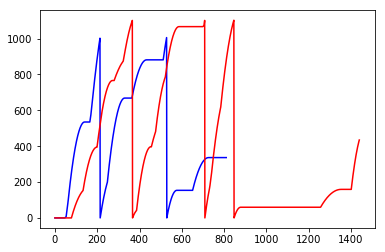

In [101]:
intfi_couple = coupled_integ_fire(T, T_drink, Q, 2, n=n, delta = 10)
plt.plot(T, intfi_couple[0][0], 'b')
plt.plot(T, intfi_couple[0][1], 'r')
plt.show()